In [62]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd '../HOTS'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/antoine/homhots/HOTS/HOTS


In [63]:
import time
def tic():
    global ttic
    ttic = time.time()
def toc():
    print(f'Done in {time.time() - ttic:.3f} s')

# loading raw dataset

In [64]:
import numpy as np
import tonic

download = False
learn_set = tonic.datasets.NMNIST(save_to='../Data/',
                                  train=True, download=download,
                                  transform=tonic.transforms.AERtoVector()
                                 )
nb_pola = 2
name = 'raw'

In [65]:
records_path = '../Records'
timestr = '2021-02-16'
ds = 12
nb_train = int(len(learn_set)//ds)
print(f'The dataset has size {len(learn_set)}, using {nb_train}')

The dataset has size 60000, using 5000


# loading output of HOTS as a dataset

In [66]:
from mix_Network import network
name = 'homhots'
sigma = None
pooling = False
homeinv = False
jitonic = [None,None] #[temporal, spatial]
jitter = False
tau = 5
nblay = 3
nbclust = 4
filt = 2
def netparam(name, filt, tau, nblay, nbclust, sigma, homeinv, jitter):
    if name=='hots':
        homeo = False
        homeotest = False
        krnlinit = 'first'
        hotshom = network(krnlinit=krnlinit, filt=filt, tau=tau, nblay=nblay, nbclust=nbclust, homeo=homeo, sigma=sigma, homeinv=homeinv, jitter=jitter)
        hotshom = hotshom.learning1by1()
    elif name=='homhots':
        homeo = True
        homeotest = True
        krnlinit = 'rdn'
        hotshom = network(krnlinit=krnlinit, filt=filt, tau=tau, nblay=nblay, nbclust=nbclust, homeo=homeo, sigma=sigma, homeinv=homeinv, jitter=jitter)
        hotshom = hotshom.learningall()
    elif name=='onlyonline':
        homeo = False
        homeotest = False
        krnlinit = 'rdn'
        hotshom = network(krnlinit=krnlinit, filt=filt, tau=tau, nblay=nblay, nbclust=nbclust, homeo=homeo, sigma=sigma, homeinv=homeinv, jitter=jitter)
        hotshom = hotshom.learningall()
    return hotshom, homeotest

In [67]:
import torch
from torch.utils.data import Dataset, TensorDataset
class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    classes = [
        "0 - zero",
        "1 - one",
        "2 - two",
        "3 - three",
        "4 - four",
        "5 - five",
        "6 - six",
        "7 - seven",
        "8 - eight",
        "9 - nine",
    ]
    sensor_size = [34, 34]
    ordering = "xytp"
    
    def __init__(self, tensors, digind, transform=None, nb_pola=2):
        self.X_train, self.y_train = tensors
        assert (self.X_train.shape[0] == len(self.y_train))
        self.transform = transform
        self.digind = digind

    def __getitem__(self, index):
        events = self.X_train[self.digind[index]:self.digind[index+1]]
        if self.transform:
            events = self.transform(events, self.sensor_size, self.ordering)
        target = self.y_train[self.digind[index]]
        return events, target

    def __len__(self):
        return len(self.digind)-1

In [68]:
def get_loader(name, train=True, nb_digit=nb_train):

    hotshom, homeotest = netparam(name, filt, tau, nblay, nbclust, sigma, homeinv, jitter)
    stream = hotshom.running(homeotest = homeotest, nb_digit=nb_digit, train=train, LR=True)

    # get indices for transitions from one digit to another 
    def getdigind(stream):
        t = np.array(stream[2])
        newdig = [0]
        for i in range(len(t)-1):
            if t[i]>t[i+1]:
                newdig.append(i+1)
        newdig.append(i)
        return newdig

    events_train = np.zeros([len(stream[2]), 4])
    ordering = 'xytp'
    for i in range(4):
        events_train[:, i] = stream[i][:]

    X_train = events_train.astype(int)
    y_train = stream[4]
    digind_train = getdigind(stream)

    nb_pola = stream[-1]
    # Dataset w/o any tranformations
    train_dataset = CustomTensorDataset(tensors=(X_train, y_train), digind=digind_train,
                                        transform=tonic.transforms.AERtoVector(nb_pola = nb_pola))
    #train_loader = torch.utils.data.DataLoader(train_dataset_normal, batch_size=1)
    return train_dataset, nb_pola

learn_set, nb_pola = get_loader(name)

2021-02-16_lagorce_rdn_None_True_[0.25, 1]_[4, 8, 16]_[5000.0, 50000.0, 500000.0]_[2, 4, 8]_False
../Records/EXP_03_NMNIST/train/2021-02-16_lagorce_rdn_None_True_[0.25, 1]_[4, 8, 16]_[5000.0, 50000.0, 500000.0]_[2, 4, 8]_False_5000_[None, None]_homeo.pkl


# fitting LR on the output of HOTS

In [69]:
import torch
from torch.utils.data import TensorDataset, DataLoader
torch.set_default_tensor_type("torch.DoubleTensor") # -> torch.tensor([1.2, 3]).dtype = torch.float64
# https://sebastianraschka.com/faq/docs/pytorch-crossentropy.html
#criterion = torch.nn.NLLLoss(reduction="mean") # loss divided by output size
criterion = torch.nn.BCELoss(reduction="mean") # loss divided by output size

class LogisticRegressionModel(torch.nn.Module):
    #torch.nn.Module -> Base class for all neural network modules
    def __init__(self, N, n_classes, bias=True):
        super(LogisticRegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(N, n_classes, bias=bias)
        self.nl = torch.nn.Softmax(dim=1)

    def forward(self, factors):
        return self.nl(self.linear(factors))

In [70]:
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 5 + 1
#num_epochs = 2 ** 9 + 1
num_epochs

33

In [71]:
# batch_size = 256
n_classes=10
amsgrad = False # gives similar results
amsgrad = True  # gives similar results

def fit_data(dataset, 
            nb_digit,
            nb_pola,
            learning_rate=learning_rate,
            num_epochs=num_epochs,
            betas=betas,
            verbose=False, #**kwargs
        ):

    generator = torch.Generator().manual_seed(42)
    sampler = torch.utils.data.RandomSampler(dataset, replacement=True, num_samples=nb_digit, generator=generator)
    loader = tonic.datasets.DataLoader(dataset, sampler=sampler)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f'device -> {device}')

    N = dataset.sensor_size[0]*dataset.sensor_size[1]*nb_pola
    n_classes = len(dataset.classes)
    logistic_model = LogisticRegressionModel(N, n_classes)
    print(N, n_classes)
    logistic_model = logistic_model.to(device)
    logistic_model.train()
    optimizer = torch.optim.Adam(
        logistic_model.parameters(), lr=learning_rate, betas=betas, amsgrad=amsgrad
    )

    for epoch in range(int(num_epochs)):
        losses = []
        for X, label in loader:
            X, label = X.to(device), label.to(device)
            X, label = X.squeeze(0), label.squeeze(0) # just one digit = one batch
        
            outputs = logistic_model(X)

            n_events = X.shape[0]
            labels = label*torch.ones(n_events).type(torch.LongTensor).to(device)
            labels = torch.nn.functional.one_hot(labels, num_classes=n_classes).type(torch.DoubleTensor).to(device)

            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.5f}")
            
    return logistic_model, losses

In [74]:
import pickle
from os.path import isfile

f_name = records_path+'/EXP_03_NMNIST/models/'+timestr+f'_LR_{name}_{nb_train}.pkl'
if isfile(f_name):
    with open(f_name, 'rb') as file:
        model = pickle.load(file)
else:
    tic()
    model, loss = fit_data(learn_set, 
                nb_train,
                nb_pola,           
                learning_rate=learning_rate,
                num_epochs=num_epochs,
                betas=betas,
                verbose=True,
            )
    toc()
    f_name = records_path+'/EXP_03_NMNIST/models/'+timestr+f'_LR_{name}_{nb_train}.pkl'
    with open(f_name, 'wb') as file:
        pickle.dump(model, file, pickle.HIGHEST_PROTOCOL)

# testing output of HOTS as a dataset

In [75]:
test_set = tonic.datasets.NMNIST(save_to='../Data/',
                                train=False, download=download,
                                transform=tonic.transforms.AERtoVector())

In [76]:
nb_test = int(len(test_set)//ds)
print(f'The dataset has size {len(test_set)}, using {nb_test}')

The dataset has size 10000, using 833


In [77]:
test_set, nb_pola = get_loader('homhots', train=False, nb_digit=nb_test)

2021-02-16_lagorce_rdn_None_True_[0.25, 1]_[4, 8, 16]_[5000.0, 50000.0, 500000.0]_[2, 4, 8]_False
../Records/EXP_03_NMNIST/test/2021-02-16_lagorce_rdn_None_True_[0.25, 1]_[4, 8, 16]_[5000.0, 50000.0, 500000.0]_[2, 4, 8]_False_833_[None, None]_homeo.pkl


In [78]:
def predict_data(test_set, model, 
            verbose=False, **kwargs
        ):
    
    with torch.no_grad():

        generator=torch.Generator().manual_seed(42)
        sampler = torch.utils.data.RandomSampler(test_set, replacement=True, num_samples=nb_test, generator=generator)
        loader = tonic.datasets.DataLoader(test_set, sampler=sampler)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        logistic_model = model.to(device)

        pred_target, true_target = [], []

        for X, label in loader:
            X = X.to(device)
            X, label = X.squeeze(0), label.squeeze(0)

            n_events = X.shape[0]
            labels = label*torch.ones(n_events).type(torch.LongTensor)

            outputs = logistic_model(X)

            pred_target.append(torch.argmax(outputs, dim=1).cpu().numpy())
            true_target.append(labels.numpy())

    return pred_target, true_target

In [79]:
pred_target, true_target = predict_data(test_set, model)

In [115]:
accuracy = []
onlinac = np.zeros(10000) # vector that has size bigger than all event stream size
for pred_target_, true_target_ in zip(pred_target, true_target):
    accuracy.append(np.mean(pred_target_ == true_target_))
    fill_pred = pred_target_[-1]*np.ones(len(onlinac)-len(pred_target_))
    fill_true = true_target_[-1]*np.ones(len(onlinac)-len(pred_target_))
    pred_target_ = np.concatenate([pred_target_,fill_pred])
    true_target_ = np.concatenate([true_target_,fill_true])
    onlinac+=(pred_target_ == true_target_)
print(f'{np.mean(accuracy)=:.3f}')

np.mean(accuracy)=0.889


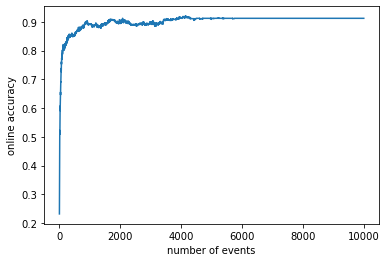

In [127]:
import matplotlib.pyplot as plt
plt.plot(onlinac/nb_test);
plt.xlabel('number of events');
plt.ylabel('online accuracy');